# Using Featuretools to Predict Missed Appointments
In this notebook, we use [Featuretools](https://github.com/Featuretools/featuretools) to automatically generate features relating to when patients don't show up for doctor appointments. We quickly reconstruct the features that were made by hand in the most popular [kernel](https://www.kaggle.com/somrikbanerjee/predicting-show-up-no-show) and make some other interesting features automatically.

In [1]:
import utils
import numpy as np
import pandas as pd
import featuretools as ft
print('Featuretools version {}'.format(ft.__version__))

data = utils.load_data("data/KaggleV2-May-2016.csv")
data.head(3)

Featuretools version 0.6.0
110527 Appointments, 14 Columns
Appointments: 110527
Schedule times: 103549
Patients: 62299
Neighborhoods: 81


,patient_id,appointment_id,gender,scheduled_time,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
AppointmentID,,,,,,,,,,,,,,
5642903,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,JARDIM DA PENHA,False,True,False,False,False,False,False
5642503,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,False,False,False,False,False,False
5642549,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,MATA DA PRAIA,False,False,False,False,False,False,False


This dataset is a single table of appointments with more than sixty thousand unique patients. Each row represents a scheduled appointment and our goal is to predict if the patient actually shows up for that appointment. From that table, we use Featuretools to automatically generate the features below.

## Structuring the Data
We are given a single table of data. Feature engineering requires that we use what we understand about the data to build numeric rows (feature vectors) which we can use as input into machine learning algorithms. The primary benefit of Featuretools is that it does not require you make those features by hand. The requirement instead is that you pass in what you know about the data.

That knowledge is stored in a Featuretools [EntitySet](https://docs.featuretools.com/loading_data/using_entitysets.html). `EntitySets` are a collection of tables with  information about relationships between tables and semantic typing for every column. We're going to show how to
+ pass in information about semantic types of columns,
+ load in a dataframe to an `EntitySet` and
+ tell the `EntitySet` about reasonable new `Entities` to make from that dataframe.

In [2]:
# List the semantic type for each column

import featuretools.variable_types as vtypes
variable_types = {'gender': vtypes.Categorical,
                  'patient_id': vtypes.Categorical,
                  'age': vtypes.Ordinal,
                  'scholarship': vtypes.Boolean,
                  'hypertension': vtypes.Boolean,
                  'diabetes': vtypes.Boolean,
                  'alcoholism': vtypes.Boolean,
                  'handicap': vtypes.Boolean,
                  'no_show': vtypes.Boolean,
                  'sms_received': vtypes.Boolean}

The `variable_types` dictionary is a place to store information about the semantic type of each column. While many types can be detected automatically, some are necessarily tricky. As an example, computers tend to read `age` as numeric. Even though ages are numbers, it's can be useful to think of them as `Categorical` or `Ordinal`. Changing the variable type will change which functions are automatically applied to generate features.

Next, we make an entity `appointments`:

In [3]:
# Make an entity named 'appointments' which stores dataset metadata with the dataframe
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id="appointments",
                              dataframe=data,
                              index='appointment_id',
                              time_index='scheduled_time',
                              secondary_time_index={'appointment_day': ['no_show', 'sms_received']},
                              variable_types=variable_types)
es['appointments']

Entity: appointments
  Variables:
    appointment_id (dtype: index)
    scheduled_time (dtype: datetime_time_index)
    appointment_day (dtype: datetime)
    neighborhood (dtype: categorical)
    gender (dtype: categorical)
    patient_id (dtype: categorical)
    age (dtype: ordinal)
    scholarship (dtype: boolean)
    hypertension (dtype: boolean)
    diabetes (dtype: boolean)
    alcoholism (dtype: boolean)
    handicap (dtype: boolean)
    no_show (dtype: boolean)
    sms_received (dtype: boolean)
  Shape:
    (Rows: 110527, Columns: 14)

We have turned the dataframe into an entity by calling the function `entity_from_dataframe`. Notice that we specified an index, a time index, a secondary time index and the `variable_types` from the last cell as keyword arguments. 

The time index and secondary time index notate what time the data is recorded. By doing that, we can avoid using data from the future while creating features. Since the label is in the dataframe, we either need to specify a time index or drop the column entirely.

Finally, we build new entities from our existing one using `normalize_entity`. We take unique values from `patient`, `age`, `neighborhood` and `gender` and make a new `Entity` for each whose rows are the unique values. To do that we only need to specify where we start (`appointments`), the name of the new entity (e.g. `patients`) and what the index should be (e.g. `patient_id`). Having those additional `Entities` and `Relationships` tells the algorithm about reasonable groupings which allows for some neat aggregations.

In [4]:
# Make a patients entity with patient-specific variables
es.normalize_entity('appointments', 'patients', 'patient_id',
                    additional_variables=['scholarship',
                                          'hypertension',
                                          'diabetes',
                                          'alcoholism',
                                          'handicap'])

# Make locations, ages and genders
es.normalize_entity('appointments', 'locations', 'neighborhood',
                    make_time_index=False)
es.normalize_entity('appointments', 'ages', 'age',
                    make_time_index=False)
es.normalize_entity('appointments', 'genders', 'gender',
                    make_time_index=False)

Entityset: Appointments
  Entities:
    appointments [Rows: 110527, Columns: 9]
    patients [Rows: 62299, Columns: 7]
    locations [Rows: 81, Columns: 1]
    ages [Rows: 104, Columns: 1]
    genders [Rows: 2, Columns: 1]
  Relationships:
    appointments.patient_id -> patients.patient_id
    appointments.neighborhood -> locations.neighborhood
    appointments.age -> ages.age
    appointments.gender -> genders.gender

In [5]:
# Show the patients entity
es['patients'].df.head(2)

,patient_id,scholarship,hypertension,diabetes,alcoholism,handicap,first_appointments_time
832256398961987,832256398961987,False,False,False,False,False,2015-11-10 07:13:56
91637474953513,91637474953513,False,True,False,False,False,2015-12-03 08:17:28


## Visualize EntitySet

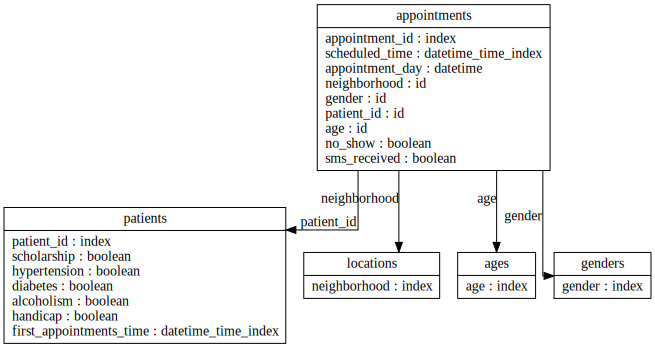

In [6]:
es.plot()

## Generating Features with Deep Feature Synthesis
With our data  structued in an `EntitySet`, we can immediately build features across our entity and relationships with Deep Feature Synthesis (DFS). As an example, the feature `locations.PERCENT_TRUE(no_show)` will calculate percentage of patients of at this location that haven't shown up in the past.

This is where the time indices get used. We set the `cutoff_time` for each row to be when the patient schedules the appointment. That means that DFS, while building features, will only use the data that is known as the appointment is made. In particular, it won't use the label to create features.

In [7]:
# Take the index and the appointment time to use as a cutoff time
cutoff_times = es['appointments'].df[['appointment_id', 'scheduled_time', 'no_show']].sort_values(by='scheduled_time')

# Rename columns to avoid confusion
cutoff_times.rename(columns = {'scheduled_time': 'cutoff_time', 
                               'no_show': 'label'},
                    inplace = True)

In [8]:
# Generate features using the constructed entityset
fm, features = ft.dfs(entityset=es,
                      target_entity='appointments',
                      agg_primitives=['count', 'percent_true'],
                      trans_primitives=['is_weekend', 'weekday', 'day', 'month', 'year'],
                      max_depth=3,
                      approximate='6h',
                      cutoff_time=cutoff_times[20000:],
                      verbose=True)

Built 40 features
Elapsed: 05:26 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


We have applied and stacked **primitives** like `MONTH`, `WEEKDAY` and `PERCENT_TRUE` to build features accross all the `Entities` in our `EntitySet`.

Feel free to fork this kernel and modify the parameters. By doing so, you can get very different feature matrices. Here's a short overview of the keywords used:
+ `target_entity` is the entity for which we're building features. It would be equally easy to make a feature matrix for the `locations` entity
+ `agg_primitives` and `trans_primitives` are lists of which primitives will be used while constructing features. The full list can be found by running `ft.list_primitives()`
+ `max_depth=3` says to stack up to 3 primitives deep.
+ `approximate='6h'` rounds cutoff times into blocks that are 3 hours long for faster computation
+ `cutoff_time` is a dataframe that says when to calculate each row
+ `verbose=True` makes the progress bar

For more information, see the [documentation](https://docs.featuretools.com/automated_feature_engineering/afe.html) of dfs.
## Machine Learning
We can put the created feature matrix directly into sklearn. Similar to the other kernels, we do not do a good job predicting no-shows. With one unshuffled train test split, our `roc_auc_score` is roughly .5 with similar scores for F1 and K-first. 

In [9]:
cols = [c for c in fm.columns if c != 'no_show']
fm = fm[cols]

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

X = fm.copy()
label = X.pop('label')
X = X.drop(['patient_id', 'neighborhood', 'gender'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.30, shuffle=False)
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
print('AUC score of {:.3f}'.format(roc_auc_score(y_test, probs[:,1])))

AUC score of 0.525


In [11]:
X_train.columns

Index(['age', 'sms_received', 'IS_WEEKEND(scheduled_time)',
       'IS_WEEKEND(appointment_day)', 'WEEKDAY(scheduled_time)',
       'WEEKDAY(appointment_day)', 'DAY(scheduled_time)',
       'DAY(appointment_day)', 'MONTH(scheduled_time)',
       'MONTH(appointment_day)', 'YEAR(scheduled_time)',
       'YEAR(appointment_day)', 'patients.COUNT(appointments)',
       'patients.PERCENT_TRUE(appointments.no_show)',
       'patients.PERCENT_TRUE(appointments.sms_received)',
       'patients.WEEKDAY(first_appointments_time)',
       'patients.DAY(first_appointments_time)',
       'patients.MONTH(first_appointments_time)',
       'patients.YEAR(first_appointments_time)',
       'locations.COUNT(appointments)',
       'locations.PERCENT_TRUE(appointments.no_show)',
       'locations.PERCENT_TRUE(appointments.sms_received)',
       'ages.COUNT(appointments)', 'ages.PERCENT_TRUE(appointments.no_show)',
       'ages.PERCENT_TRUE(appointments.sms_received)',
       'genders.COUNT(appointments)',
  

In [12]:
feature_imps = [(imp, X.columns[i]) for i, imp in enumerate(clf.feature_importances_)]
feature_imps.sort()
feature_imps.reverse()
print('Random Forest Feature Importances:')
for i, f in enumerate(feature_imps[0:8]):
    print('{}: {} [{:.3f}]'.format(i + 1, f[1], f[0]/feature_imps[0][0]))

Random Forest Feature Importances:
1: locations.COUNT(appointments) [1.000]
2: ages.COUNT(appointments) [0.904]
3: age [0.890]
4: DAY(appointment_day) [0.773]
5: locations.PERCENT_TRUE(appointments.no_show) [0.636]
6: locations.PERCENT_TRUE(appointments.sms_received) [0.632]
7: ages.PERCENT_TRUE(appointments.no_show) [0.624]
8: ages.PERCENT_TRUE(appointments.sms_received) [0.618]


In [13]:
p1 = utils.plot_roc_auc(y_test, probs)
p2 = utils.plot_f1(y_test, probs, 1000)
p3 = utils.plot_kfirst(y_test, probs, 300)

Loading BokehJS ...

/Users/lecrintech/projects/python/demos-featuretools/demo2/v0.6.0/predict-appointment-noshow/env3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lecrintech/projects/python/demos-featuretools/demo2/v0.6.0/predict-appointment-noshow/env3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Loading BokehJS ...

Loading BokehJS ...

In [14]:
from bokeh.io import show
from bokeh.layouts import gridplot
show(gridplot([p1, p2, p3], ncols=1))

# Some Plots
An interesting workflow with this dataset is to plot generated features to learn about the data. Here, we'll show the number of visits by neighborhood, and the likelihood to show up by neighborhood and age as created by DFS.

In [15]:
p4 = utils.plot_locations(fm)
p5 = utils.plot_noshow_by_loc(fm)
p6 = utils.plot_ages(fm)
p7 = utils.plot_noshow_by_age(X)

In [16]:
show(gridplot([p4, p6, p5, p7], ncols=2)) 

<a href="https://www.featurelabs.com/">
    <img src="http://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</a>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact).